In [52]:
import pandas as pd
import glob
import re
import xlrd
import os
import numpy as np
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV #随机网格优化的库
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score,classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [24]:
SEED = 6657

In [10]:
df = pd.read_excel('train.xlsx')

In [11]:
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,popularity_bin,song_id
0,0.00408,0.582,189376,0.491,1,0.000000,1,0.0941,-10.772,1,0.4000,98.766,0.313,2018,0,FiBZczNKae25352
1,0.25900,0.728,227234,0.542,1,0.000000,0,0.1360,-5.195,1,0.0514,90.016,0.637,2019,1,BdEo0DubAf81235
2,0.96900,0.369,123227,0.472,0,0.000000,0,0.9370,-21.784,1,0.8590,151.161,0.132,2012,0,trymlADmcf31126
3,0.01180,0.614,182133,0.984,0,0.000000,1,0.6500,-2.419,0,0.0773,142.002,0.776,2012,1,mrWrFR5byJ10481
4,0.53200,0.328,240173,0.498,0,0.000079,4,0.1170,-10.898,0,0.1260,175.918,0.360,2012,1,Uet29yjBPm37465


In [12]:
df.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'year', 'popularity_bin', 'song_id'],
      dtype='object')

In [16]:
df=df[['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'year', 'popularity_bin']]

In [17]:
df = pd.get_dummies(df)

In [20]:
df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year,popularity_bin
0,0.00408,0.582,189376,0.491,1,0.000000,1,0.0941,-10.772,1,0.4000,98.766,0.313,2018,0
1,0.25900,0.728,227234,0.542,1,0.000000,0,0.1360,-5.195,1,0.0514,90.016,0.637,2019,1
2,0.96900,0.369,123227,0.472,0,0.000000,0,0.9370,-21.784,1,0.8590,151.161,0.132,2012,0
3,0.01180,0.614,182133,0.984,0,0.000000,1,0.6500,-2.419,0,0.0773,142.002,0.776,2012,1
4,0.53200,0.328,240173,0.498,0,0.000079,4,0.1170,-10.898,0,0.1260,175.918,0.360,2012,1


In [21]:
x = df[['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence', 'year']]

In [22]:
y = df[['popularity_bin']]

In [27]:
len(df[df['popularity_bin']==1])

17059

In [28]:
len(df[df['popularity_bin']==0])

15366

In [25]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=SEED)

In [29]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state=SEED)

In [34]:
rf.fit(xtrain, ytrain)
predictions = rf.predict(xtest)
predictions = [round(value) for value in predictions]
accuracy_score(ytest, predictions)

C:\Users\gsy19\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.856437933693138

In [36]:
n_estimators=[int(x)for x in np.linspace(start=20,stop=2000,num=10)]#森林中树的数量，部分数值由经验数据确认
max_features=['auto','sqrt'] #最大特征数取法
max_depth=[int(x)for x in np.linspace(10,20,num=2)]#树最大深度
max_depth.append(None)#加入无上限的可能
min_sample_split=[2,5,10]#最小分裂样本数，当样本数小于此值时，则不会继续分裂
min_sample_leaf=[1,2,4]#最小叶子节样本数，即叶子节点必须大于此确定的样本数，否则会被剪枝
bootstrap=[True,False]
random_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_sample_split,
            'min_samples_leaf':min_sample_leaf,
            'bootstrap':bootstrap} #完成待调参数

In [39]:
rf=RandomForestRegressor()
rf_random=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,scoring='accuracy',cv=3,verbose=2,random_state=42,n_jobs=-1)
rf_random.fit(xtrain,ytrain)#训练调参模型
rf_best_param=rf_random.best_params_
rf_best_param#得到最优参数

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 680,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [42]:
rf2 = RandomForestRegressor(n_estimators=680, random_state=SEED,min_samples_split=2,min_samples_leaf=4,max_features='auto',max_depth=None,bootstrap=True)
rf2.fit(xtrain, ytrain)
predictions = rf2.predict(xtest)
predictions = [round(value) for value in predictions]
accuracy_score(ytest, predictions)

C:\Users\gsy19\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8530454895913647

In [50]:
importances = list(rf2.feature_importances_)#此rf自带的方法可返回各feature的重要性
feature_importance=[(feature, round(importance,2))for feature,importance in zip(x.columns,importances)]#将feature名和其重要性组合
feature_importance =sorted(feature_importance,key = lambda x:x[1],reverse = True)#以第二个参数进行排列，即按重要性排列
sorted_importance = [importance[1] for importance in feature_importance]#将排列好的重要性加入list中
sorted_features = [importance[0] for importance in feature_importance]#将排列好的feature名加入list中
cumlative_importances = np.cumsum(sorted_importance)#numpy中的累加函数，会进行依次累加，且将每次累加的和输出存储

Text(0.5, 1.0, 'Cumlative Importances')

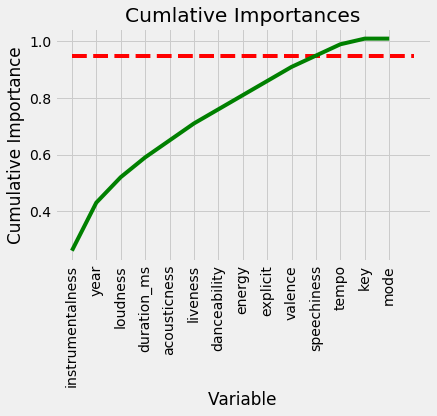

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.plot(sorted_features, cumlative_importances,'g-')
plt.hlines(y=0.95, xmin=0, xmax=len(sorted_importance),color='r',linestyles='dashed')#95%的曲线，一般对影响95%的预测的feature感兴趣
plt.xticks(sorted_features,rotation='vertical')
plt.xlabel('Variable');plt.ylabel('Cumulative Importance');plt.title('Cumlative Importances')

In [46]:
lr1 = LogisticRegression()#先建立一个逻辑回归函数
param_grid=[{'C':[0.01,0.1,1,10,100]}] #需要选择的参数范围
grid_search = GridSearchCV(lr1,param_grid,cv=5,scoring='accuracy') #建立调参模型，CV表示KFOLD次数，Scoring表示结果评判标准，可按情况取其他值
grid_search.fit(xtrain, ytrain)#训练模型
grid_search.best_params_#返回最优参数

C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

{'C': 0.1}

In [47]:
lr2 = LogisticRegression(C=0.1)

In [48]:
lr2.fit(xtrain, ytrain)
predictions = lr2.predict(xtest)
predictions = [round(value) for value in predictions]
accuracy_score(ytest, predictions)

C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5747108712413261

In [49]:
model = XGBClassifier()
model.fit(xtrain,ytrain)
y_pred = model.predict(xtest)
predictions = [round(value) for value in y_pred]
accuracy_score(ytest, predictions)

C:\Users\gsy19\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8309946029298381

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [ ]:
def get_models():#生成基础模型集合（模板中的基础模型都为默认参数模型，SEED为预先确定的随机数种子，在实际训练过程中，可先调参基础模型提升最终预测能力）
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)
    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models

base_learners=get_models()#得到基础模型

In [ ]:
meta_learners=GradientBoostingClassifier(n_estimators=1000,loss='exponential',max_features=4,max_depth=3,subsample=0.5,learning_rate=0.005,random_state=SEED)

In [ ]:
from mlens.ensemble import SuperLearner#并行集成工具库，可提升训练速度
s1=SuperLearner(folds=10,random_state=SEED,verbose=2,backend="multiprocessing")
s1.add(list(base_learners.values()),proba=True)#加入基础模型
s1.add_meta(meta_learners,proba=True)#加入集成模型
s1.fit(xtrain,ytrain)
p_s1 = s1.predict_proba(xtest)
predictions = [round(value) for value in p_s1]
accuracy_score(ytest, predictions)